# Creating a US COVID-19 Dashboard Web App


#### Section 1: Introduction

The goal of this project is to practice reading new package documentation and examples to develop a python dashboard. The dashboard will be created  using Dash, a python framework for creating interactive web applications. To achieve this goal, I will be using the pandas library for data manipulation and aggregation, and plotly for plotting figures.

#### Section 2: Dataset description

For the purposes of this project, I will be using the datasets ***COVID-19 Vaccinations in the United States,County***, which I will be calling ***covid_df***, ***United States COVID-19 County Level of Community Transmission as Originally Posted***, which I will be calling ***covid_df3***, and ***state_abbrev***, acquired from (https://worldpopulationreview.com/states/state-abbreviations). The two COVID-19 datasets were acquired from public domain, [Centers for Disease Control and Prevention](https://data.cdc.gov).

The columns we will be using will be for ***covid_df*** is:

- Date - date of data collection

- FIPS - Federal Information Processing Standard State Code

- Recip_County - County of residence

- Recip_State - Recipient State

- Administered_Dose1_Pop_Pct - Percent of Total Pop with at least one Dose by State of Residence

- Series_Complete_Pop_Pct - Percent of people who are fully vaccinated (have second dose of a two-dose vaccine or one dose of a single-dose vaccine)



and the columns for ***covid_df3***:

- state_name
- county_name 
- report_date
- cases_per_100K_7_day_count_change
- percent_test_results_reported_positive_last_7_days

##### Cleaning covid_df
In order to work with these datasets, I will be performing basic data cleaning. Using pandas, I will only read in the columns I need to save memory and processing power. The COVID-19 datasets contain states and other US territories, which we will filter to the 50 US states. 

In [14]:
covid_df = pd.read_csv("vax_us_county.csv",
                      usecols = ['Date',"FIPS",'Recip_County', 'Recip_State','Administered_Dose1_Pop_Pct', 'Series_Complete_Pop_Pct'], parse_dates = ["Date"])


us_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
covid_df = covid_df[covid_df.Recip_State.isin(us_states)]

The below code converts dates to int in a new column 'dates' , using strftime from the library datetime. This is so we can sort these dates using the 'sort_values' function in order for proper graphing using plotly using 'dates' as an input in the dash app. The slider in dash app does not work datetime objects; thus we convert the datetime objects from 'Date' columns to int format in 'dates'. Then we assign a number in ascending order to each unique value in dates to in columns 'numbers.'

In [12]:
#stripping datetime value to numbers format
covid_df['dates'] = covid_df['Date'].apply(lambda x: int(x.strftime("%Y%m%d")))
#sort dates before mapping
covid_df.sort_values(by = 'dates', ascending = True, inplace = True)

#create dictionary for mapping, unique dates for numbers
mapping = {item:i for i, item in enumerate(covid_df["dates"].unique())}
#map dates to numbers in a new column
covid_df["numbers"] = covid_df["dates"].apply(lambda x: mapping[x])
covid_df.head(5)

,Date,FIPS,Recip_County,Recip_State,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,dates,numbers
1194488,2020-12-13,20095.0,Kingman County,KS,0.0,0.0,20201213,0
1192345,2020-12-13,20003.0,Anderson County,KS,0.0,0.0,20201213,0
1192344,2020-12-13,48395.0,Robertson County,TX,0.0,0.0,20201213,0
1192343,2020-12-13,35023.0,Hidalgo County,NM,0.0,0.0,20201213,0
1192342,2020-12-13,21099.0,Hart County,KY,0.0,0.0,20201213,0


##### Cleaning covid_df3
For covid_df3, the 'state_name' column has full state names, unlike covid_df. For coherency and proper functionality with plotly in Dash, I will be using state_abbrev to create dictionary 'state_dict'. 'state_dict will allow me to create a new column in covid_df3 to create a new column 'code', which will have the state abbreviations. I also do the same process of filtering to only US states.

In [13]:
#state df to map state to state code for df3
state_abbrev = pd.read_csv("state_abbrev")
state_dict = dict(zip(state_abbrev.State, state_abbrev.Code))


covid_df3 = pd.read_csv("us_county_trans.csv",
                       usecols = ['state_name', 'county_name' ,'report_date', 'cases_per_100K_7_day_count_change','percent_test_results_reported_positive_last_7_days'],
                       na_values = "suppressed")

#make new column for state codes
covid_df3['code'] = covid_df3.state_name.map(state_dict)
#filter out non-states
covid_df3 = covid_df3[covid_df3.code.isin(us_states)]
covid_df3.dropna(inplace = True)
#dict to map state and county
dropdowndict = covid_df3.groupby('code')['county_name'].apply(list).to_dict()

#convert dates
covid_df3['dates'] = pd.to_datetime(covid_df3.report_date, format ='%Y/%m/%d')
covid_df3.sort_values(by = 'dates', inplace = True)

covid_df3.head(5)

,state_name,county_name,report_date,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days,code,dates
1,South Dakota,Corson County,2021/08/16,244.740,30.43,SD,2021-08-16
67604,Colorado,Grand County,2021/08/16,108.050,5.63,CO,2021-08-16
67602,Utah,Davis County,2021/08/16,172.160,9.71,UT,2021-08-16
67601,South Dakota,Deuel County,2021/08/16,344.750,46.67,SD,2021-08-16
67599,Oregon,Columbia County,2021/08/16,355.270,17.80,OR,2021-08-16


#### Section 3: Testing of the web app

To test the web app, I check if the graph changes when the input changes. A properly functioning web app will have the graph change according to the input the user makes. This is called a callback function: functions that are automatically called by Dash whenever an input component's property changes, in order to update some property in another component (the output). In the image below, we see a basic input of Full Dose vs One Dose, and see the graph change according to the input.

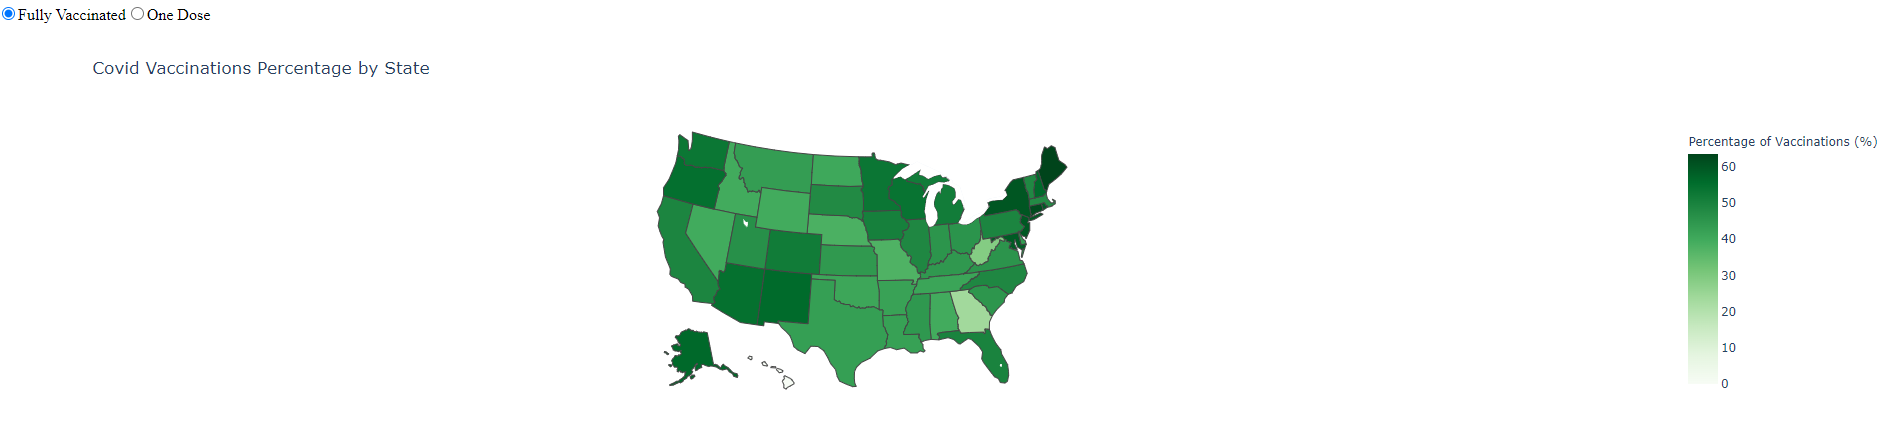
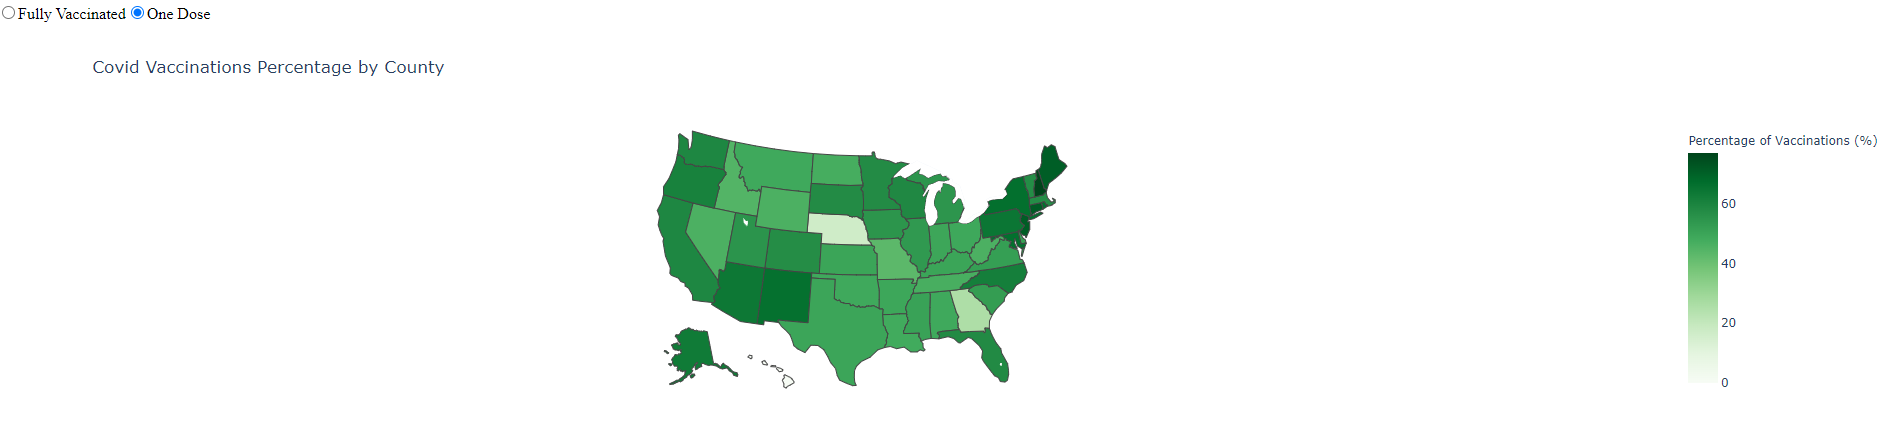

#### Section 4: Conclusion

The main goal of this project was practice reading new package documentations and examples to develop a new dashboard. In other words, develop skills in libraries that I am unfamiliar with. For someone who never worked with dash and plotly, making sure all the inputs and outputs work correctly the beginning step. Things that that can be improved in this app at the current stage is formatting the app using using html and using a range slider for figure 4. Moving forward, learning html and moving the figures to format the app would be next step in my learning process of this project.